In [1]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip

--2020-11-07 17:33:56--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  28.1MB/s    in 11s     

2020-11-07 17:34:08 (23.9 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



## Exploration

The images for each traffic sign are stored in a separate directory. How many do we have?

In [4]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

I'll create 3 helper functions that use OpenCV and Torchvision to load and show images:

In [5]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Let's have a look at some examples for each traffic sign:

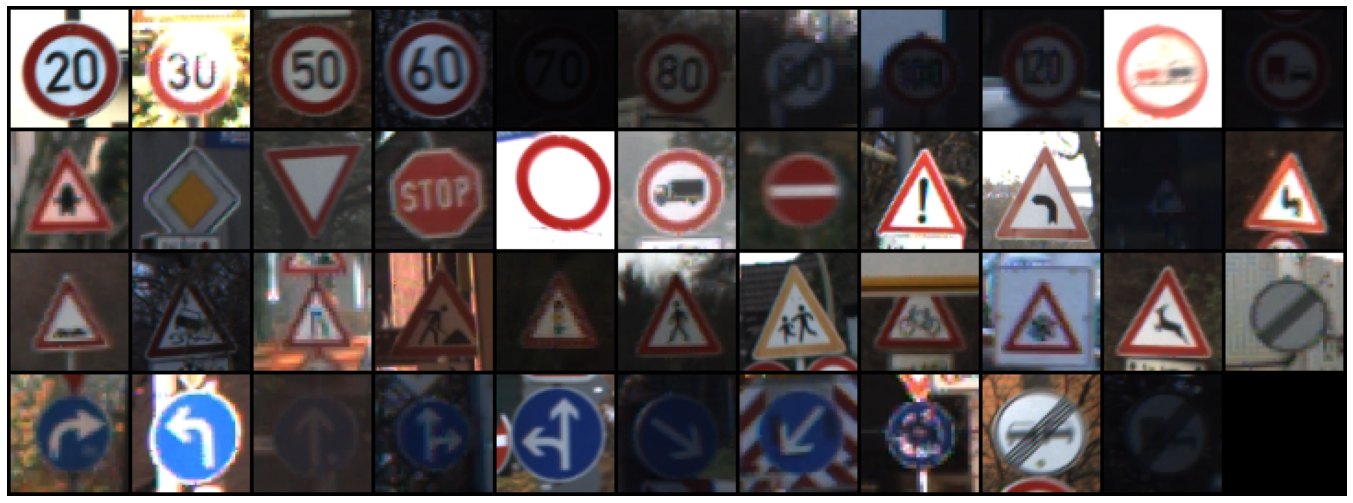

In [6]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

## Building a Dataset

To keep things simple, we'll focus on classifying some of the most used traffic signs:

In [15]:
class_names = [str(i) for i in range(0,43)]

class_indices = [i for i in range(0,43)]

Now I'll copy the images files to a new directory, so it's easier to use the Torchvision's dataset helpers. Let's start with the directories for each class:

In [16]:
#!rm -rf data

DATA_DIR = Path('data2')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

I'll reserve 80% of the images for training, 10% for validation, and 10% test for each class. We'll copy each image to the correct dataset directory:

In [17]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

0: 210
1: 2220
2: 2250
3: 1410
4: 1980
5: 1860
6: 420
7: 1440
8: 1410
9: 1470
10: 2010
11: 1320
12: 2100
13: 2160
14: 780
15: 630
16: 420
17: 1110
18: 1200
19: 210
20: 360
21: 330
22: 390
23: 510
24: 270
25: 1500
26: 600
27: 240
28: 540
29: 270
30: 450
31: 780
32: 240
33: 689
34: 420
35: 1200
36: 390
37: 210
38: 2070
39: 300
40: 360
41: 240
42: 240


I'll apply some random resizing, rotation, and horizontal flips. Finally, I'll normalize the tensors using preset values for each channel. This is a requirement of the pre-trained models in Torchvision.

In [18]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

I'll create a PyTorch dataset for each image dataset folder and data loaders for easier training:

In [19]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

In [20]:
display(print(image_datasets))

{'train': Dataset ImageFolder
    Number of datapoints: 31367
    Root location: data2/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 3921
    Root location: data2/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3921
    Root location: data2/test
    StandardTransform
Transform: Compose(
     

None

I'll also store the number of examples in each dataset and class names for later

In [21]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 3921, 'train': 31367, 'val': 3921}

## Data augmentation

I'll apply some image augmentation techniques to artificially increase the size of the training dataset:

Let's have a look at some example images with applied transformations. We also need to reverse the normalization and reorder the color channels to get correct image data

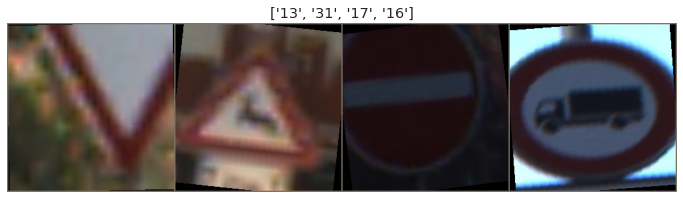

In [22]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Using a Pre-Trained Model

Here, we'll use Transfer Learning to copy the architecture of the very popular ResNet model. On top of that, we'll use the learned weights of the model from training on the ImageNet dataset . All of this is made easy to use by Torchvision:

In [23]:
def create_model(n_classes):
  model = models.resnet34(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

We reuse almost everything except the change of the output layer. This is needed because the number of classes in our dataset is different than ImageNet.

Let's create an instance of our model:

In [24]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


# Training

In [25]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

Let's start by turning our model into train mode and go over the data. After getting the predictions, we get the class with maximum probability along with the loss, so we can calculate the epoch loss and accuracy.

Note that we're also using a learning rate scheduler.

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [28]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.9059912159081914 accuracy 0.7465808014792615
Val   loss 0.29016878503364213 accuracy 0.9237439428717164

Epoch 2/10
----------
Train loss 0.4611151648823236 accuracy 0.8583862020594892
Val   loss 0.0787329065776285 accuracy 0.9724560061208875

Epoch 3/10
----------
Train loss 0.37495525483583453 accuracy 0.8838907131698919
Val   loss 0.0922546933960796 accuracy 0.973221117061974

Epoch 4/10
----------
Train loss 0.34672135594846076 accuracy 0.8907769311697006
Val   loss 0.08247926387839478 accuracy 0.9760265238459577

Epoch 5/10
----------
Train loss 0.31492839616553125 accuracy 0.9002773615583255
Val   loss 0.07864014984278173 accuracy 0.9737311910226982

Epoch 6/10
----------
Train loss 0.2965317082644769 accuracy 0.9073229827525743
Val   loss 0.07046039023238203 accuracy 0.9765365978066819

Epoch 7/10
----------
Train loss 0.2783205772442428 accuracy 0.9103197628080466
Val   loss 0.05223205377274599 accuracy 0.9836776332568222

Epoch 8/10
---------

In [29]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

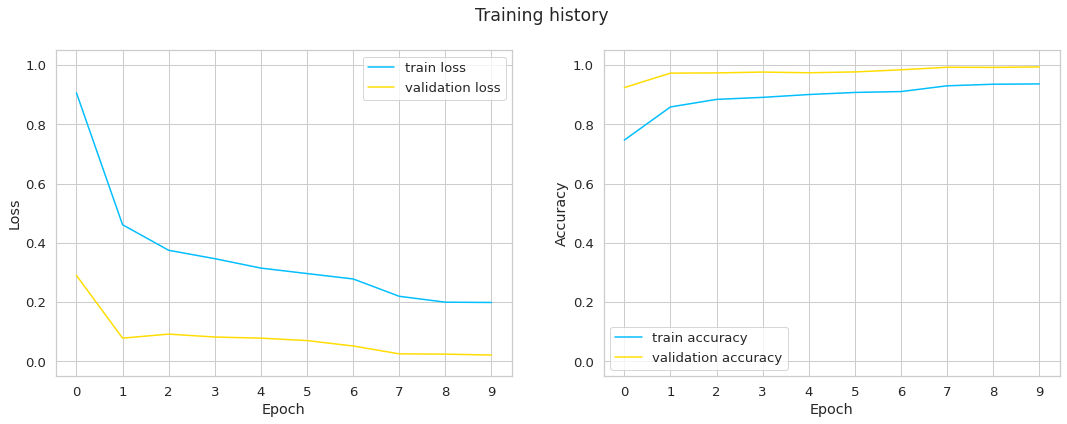

In [30]:
plot_training_history(history)

The pre-trained model is so good that we get very high accuracy and low loss after 3 epochs. Unfortunately, our validation set is too small to get some meaningful metrics from it.

# Evaluation

Let's see some predictions:

In [31]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

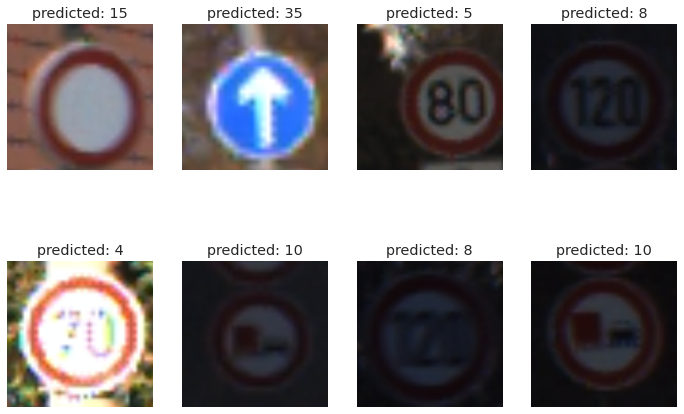

In [32]:
show_predictions(base_model, class_names, n_images=8)

In [33]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [34]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [35]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.99      1.00      0.99       222
          10       1.00      1.00      1.00       201
          11       1.00      0.99      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        78
          15       1.00      1.00      1.00        63
          16       1.00      1.00      1.00        42
          17       1.00      1.00      1.00       111
          18       0.99      1.00      1.00       120
          19       0.91      1.00      0.95        21
           2       1.00      1.00      1.00       225
          20       1.00      0.92      0.96        36
          21       1.00      1.00      1.00        33
          22       1.00      1.00      1.00        39
          23       1.00      1.00      1.00        51
          24       1.00    

The classification report shows us that our model is perfect, not something you see every day! Does this thing make any mistakes?

In [40]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  #cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  #cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=90, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

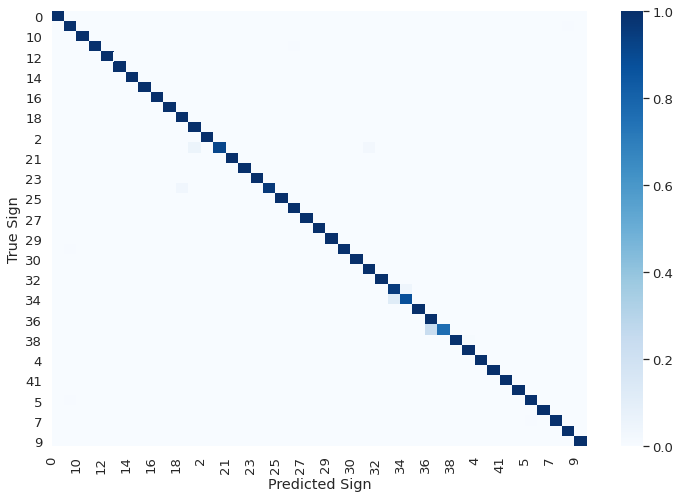

In [41]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

## Classifying unseen images

Ok, but how good our model will be when confronted with a real-world image? Let's check it out:

In [42]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr

Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 28.6MB/s]


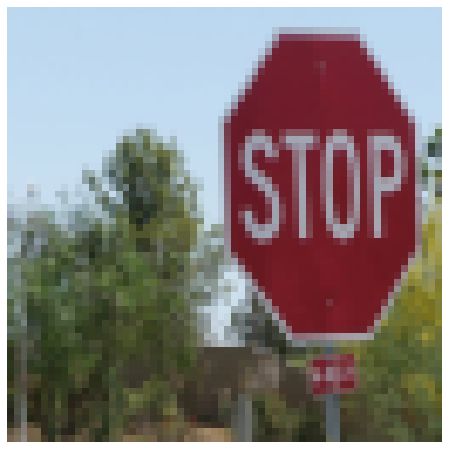

In [43]:
show_image('stop-sign.jpg')

For this, we'll have a look at the confidence for each class. Let's get this from our model:

In [44]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [45]:
pred = predict_proba(base_model, 'stop-sign.jpg')
pred

array([1.2709447e-06, 2.0825263e-04, 1.9080142e-06, 6.3517518e-07,
       3.4338623e-06, 2.9039327e-06, 9.9902427e-01, 3.6067635e-07,
       3.3914976e-08, 6.9388625e-04, 5.2276523e-06, 4.5460528e-08,
       3.9603631e-07, 1.2581724e-08, 5.0756381e-07, 2.0906081e-07,
       2.0650268e-07, 1.9881993e-06, 9.1125844e-07, 2.5836782e-06,
       1.0699438e-06, 3.0281583e-07, 4.4208355e-07, 1.1151472e-07,
       6.1933935e-07, 3.9261703e-08, 1.1566859e-07, 4.7292087e-06,
       3.1447457e-06, 3.0429629e-07, 3.3254059e-06, 6.3546813e-06,
       6.1159953e-06, 7.3426390e-06, 2.4435335e-06, 6.4583801e-06,
       2.4496103e-07, 3.1732225e-07, 4.6479894e-07, 1.1108866e-07,
       5.4409034e-06, 1.2202490e-06, 1.5542942e-07], dtype=float32)

In [46]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

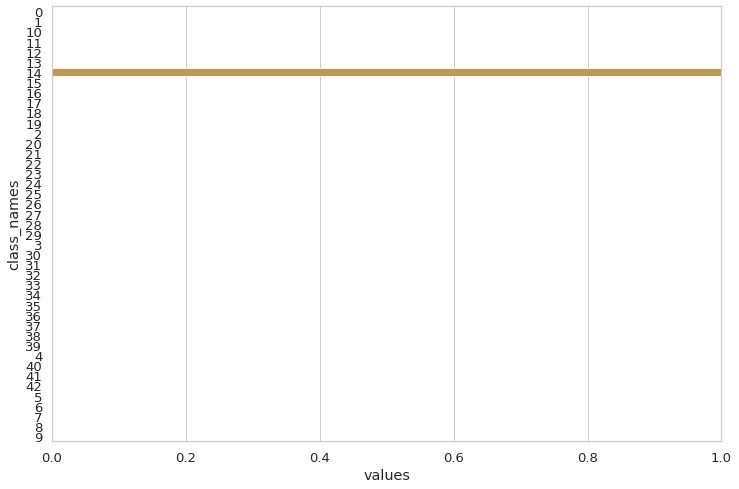

In [47]:
show_prediction_confidence(pred, class_names)